In [1]:
import warnings
from urllib3.exceptions import NotOpenSSLWarning

warnings.filterwarnings("ignore", category=NotOpenSSLWarning)

/Users/borosabel/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import spacy
spacy_nlp = spacy.load("en_core_web_sm")
import utility_functions as utils
import importlib
import pandas as pd
import seaborn as sns

# Text processing
from gensim import corpora

# Visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
from tqdm import tqdm
from gensim import models
from gensim.models.coherencemodel import CoherenceModel

importlib.reload(utils)

data = './preprocessed_df.pkl'

In [3]:
df = pd.read_pickle(data)
df[['Artist', 'Song', 'Tokens', 'Lyrics', 'Coast']].head()

,Artist,Song,Tokens,Lyrics,Coast
0,Big L,8 Iz Enuff.mp3,"[crew, house, terra, herb, mcgruff, buddah, bl...",crew house terra herb mcgruff buddah bless big...,east_coast
1,Big L,Da Graveyard.mp3,"[number, one, crew, area, big, lightin, nigga,...",number one crew area big lightin nigga incense...,east_coast
2,Big L,I Don't Understand It.mp3,"[many, mc, overrate, ask, even, suppose, make,...",many mc overrate ask even suppose make rap biz...,east_coast
3,Big L,"No Endz, No Skinz.mp3","[let, get, point, real, quick, pocket, thick, ...",let get point real quick pocket thick mad chic...,east_coast
4,Big L,MVP.mp3,"[spark, phillies, pass, stout, making, quick, ...",spark phillies pass stout making quick money g...,east_coast


In [4]:
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['Tokens'])
dictionary.filter_extremes(no_below=5, no_above=0.5)
print(f"Number of unique tokens: {len(dictionary)}")

Number of unique tokens: 5609


In [5]:
# Convert documents to a bag-of-words representation
corpus = [dictionary.doc2bow(text) for text in df['Tokens']]

In [8]:
from tqdm import tqdm
from gensim import models
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, start, limit, step, chunksize, passes, iterations, eval_every):
    coherence_values = []
    model_list = []

    # Add tqdm for progress tracking
    for num_topics in tqdm(range(start, limit, step), desc="Computing coherence"):
        model = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            chunksize=chunksize,
            passes=passes,
            iterations=iterations,
            alpha='auto',
            eta='auto',
            eval_every=eval_every
        )
        model_list.append(model)

        # Applies a sliding window and evaluates similarity of the top words in each topic. 
        coherencemodel = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )

        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
start = 2
limit = 6
step = 1
chunksize = 200
passes = 15
iterations = 100
eval_every = 10

model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=df['Tokens'],
    start=start,
    limit=limit,
    step=step,
    chunksize=chunksize,
    passes=passes,
    iterations=iterations,
    eval_every=eval_every
)

Computing coherence:   0%|          | 0/4 [00:00<?, ?it/s]/Users/borosabel/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/borosabel/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/borosabel/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/borosabel/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is com

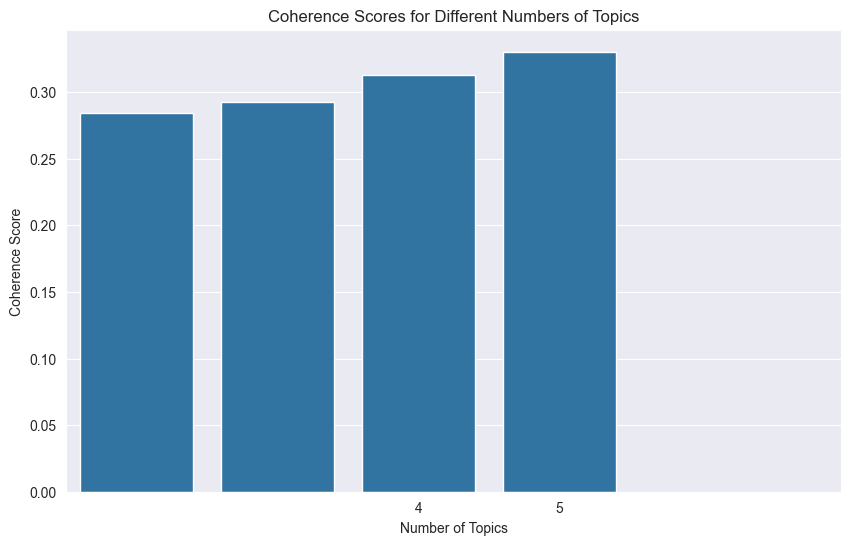

In [18]:
# Prepare data for Seaborn
x = list(range(start, limit, step))

# Create a barplot with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=x, y=coherence_values)

# Set plot labels and title
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores for Different Numbers of Topics")

# Ensure integer values on the x-axis
plt.xticks(ticks=range(start, limit, step))

plt.show()

In [19]:
# Select the model with highest coherence
optimal_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[optimal_index]
optimal_num_topics = x[optimal_index]

print(f'Optimal Number of Topics: {optimal_num_topics}')
print(f'Highest Coherence Score: {coherence_values[optimal_index]:.4f}')

Optimal Number of Topics: 5
Highest Coherence Score: 0.3303


In [20]:
# Prepare the visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(vis)

In [21]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = sorted(row_list, key=lambda x: (x[1]), reverse=True)
        # Get the dominant topic, its percentage, and keywords
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Only the dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])

                # Creating a temporary DataFrame to hold the new row
                temp_df = pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]],
                                       columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

                # Use pd.concat() instead of append
                sent_topics_df = pd.concat([sent_topics_df, temp_df], ignore_index=True)

            else:
                break

    # Add original text to the DataFrame
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename('Text')], axis=1)

    return sent_topics_df

# Apply the updated function
df_topic_sents_keywords = format_topics_sentences(
    ldamodel=optimal_model,
    corpus=corpus,
    texts=df['Lyrics']
)

# Format the output
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Display the result
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4,0.4977,"rhyme, keep, beat, rock, well, rap, think, pla...",crew house terra herb mcgruff buddah bless big...
1,1,0,0.5851,"fuck, bitch, as, motherfucker, hit, game, hoe,...",number one crew area big lightin nigga incense...
2,2,4,0.9752,"rhyme, keep, beat, rock, well, rap, think, pla...",many mc overrate ask even suppose make rap biz...
3,3,1,0.4143,"baby, girl, love, would, good, way, tell, need...",let get point real quick pocket thick mad chic...
4,4,4,0.6290,"rhyme, keep, beat, rock, well, rap, think, pla...",spark phillies pass stout making quick money g...


In [22]:
# Assuming you have a 'Region' column indicating 'East' or 'West'
df_dominant_topic['Coast'] = df['Coast']

# Calculate the distribution of topics by region (East vs West) in percentages
topic_region_dist = pd.crosstab(df_dominant_topic['Dominant_Topic'],
                                df_dominant_topic['Coast'],
                                normalize='index') * 100
print(topic_region_dist)

Coast           east_coast  west_coast
Dominant_Topic                        
0                24.878049   75.121951
1                47.727273   52.272727
2                45.454545   54.545455
3                45.081967   54.918033
4                68.831169   31.168831


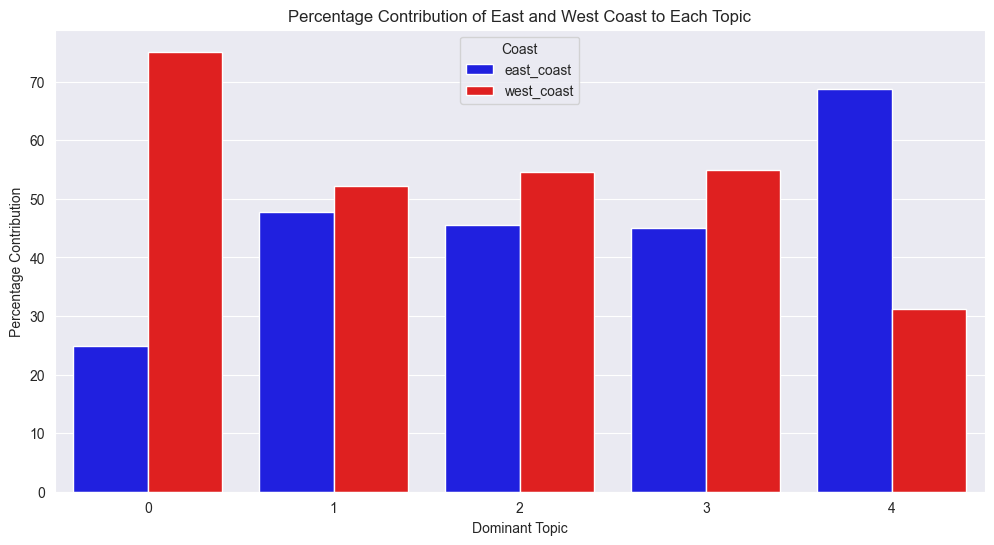

In [23]:
# Reset the index to convert 'Dominant_Topic' from index to column
topic_region_dist = topic_region_dist.reset_index()

# Melt the DataFrame for easier plotting with seaborn
topic_region_dist_melted = topic_region_dist.melt(id_vars='Dominant_Topic',
                                                  value_vars=['east_coast', 'west_coast'],
                                                  var_name='Coast',
                                                  value_name='Percentage')

# Define custom colors for East Coast (blue) and West Coast (red)
palette = {"east_coast": "blue", "west_coast": "red"}

# Create the bar plot with custom colors
plt.figure(figsize=(12, 6))
sns.barplot(x='Dominant_Topic', y='Percentage', hue='Coast', data=topic_region_dist_melted, palette=palette)

# Set plot labels and title
plt.xlabel("Dominant Topic")
plt.ylabel("Percentage Contribution")
plt.title("Percentage Contribution of East and West Coast to Each Topic")

# Show the plot
plt.show()

In [24]:
df.head()

,Artist,Album,Song,Coast,Release Year,Tempo1,Tempo2,Duration (s),Sample Rate (Hz),Path,Lyrics,Tokens
0,Big L,Lifestylez Ov Da Poor and Dangerous,8 Iz Enuff.mp3,east_coast,1995,96.774194,48.000000,298.840000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,crew house terra herb mcgruff buddah bless big...,"[crew, house, terra, herb, mcgruff, buddah, bl..."
1,Big L,Lifestylez Ov Da Poor and Dangerous,Da Graveyard.mp3,east_coast,1995,93.750000,46.511628,323.760000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,number one crew area big lightin nigga incense...,"[number, one, crew, area, big, lightin, nigga,..."
2,Big L,Lifestylez Ov Da Poor and Dangerous,I Don't Understand It.mp3,east_coast,1995,93.750000,47.244094,260.226667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,many mc overrate ask even suppose make rap biz...,"[many, mc, overrate, ask, even, suppose, make,..."
3,Big L,Lifestylez Ov Da Poor and Dangerous,"No Endz, No Skinz.mp3",east_coast,1995,100.000000,50.420168,208.733333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,let get point real quick pocket thick mad chic...,"[let, get, point, real, quick, pocket, thick, ..."
4,Big L,Lifestylez Ov Da Poor and Dangerous,MVP.mp3,east_coast,1995,86.956522,43.478261,218.866667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,spark phillies pass stout making quick money g...,"[spark, phillies, pass, stout, making, quick, ..."
